In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import scipy.stats as st
import seaborn as sns
import pandas as pd

In [2]:
# пакет для проверки множественных гипотез
from statsmodels.stats.multitest import multipletests

In [3]:
text_size = 28
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = text_size
plt.rcParams['ytick.labelsize'] = text_size
plt.rcParams['legend.fontsize'] = text_size
plt.rcParams['axes.titlesize'] = text_size
plt.rcParams['axes.labelsize'] = text_size
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = text_size

# Модельный эксперимент

## Постановка

**Данные:**

$n=20, \quad m=200, \quad m_0=150$,

$\mathbf{X}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I}), \quad i=1,\dots,m_0;$

$\mathbf{X}_i \sim \mathcal{N}(\mathbf{1}, \mathbf{I}), \quad i=m_0+1,\dots,m;$

$\mathbf{X}_i \in \mathbb{R}^n.$

**Гипотезы:**

$H^i_0: \mathsf{E}\mathbf{X}_i = 0$;

$H^i_1: \mathsf{E}\mathbf{X}_i \neq 0$;


**Критерий для проверки:**
* одновыборочный t-Критерия Стьюдента.

## Генерация данных

In [4]:
rs = np.random.RandomState(42)

alpha = 0.05
m = 200
m0 = 150
n = 20

X = rs.randn(m,n)
X[m0:]+=1

## Гистограммы

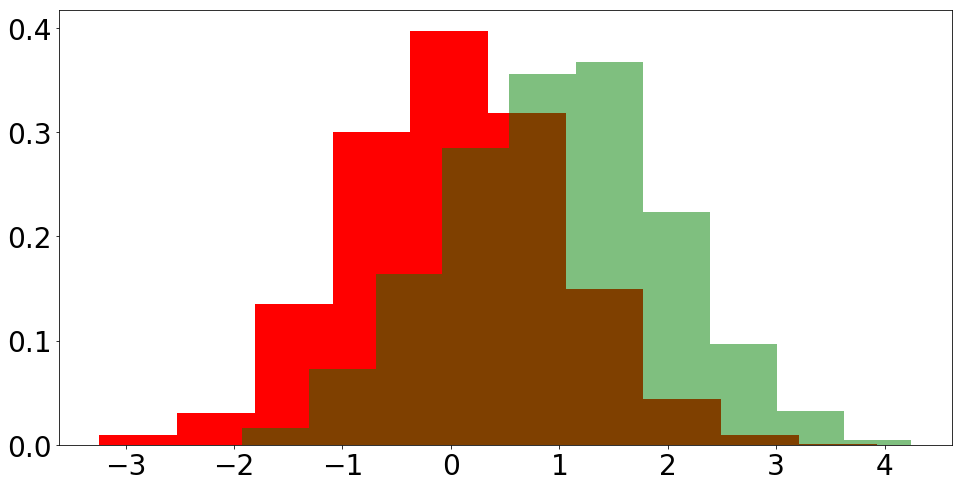

In [5]:
_ = plt.hist(X[:m0].flatten(), color='r', density=True)
_ = plt.hist(X[m0:].flatten(), color='g', alpha=0.5, density=True)

## Эксперимент

В качестве статистики использовать функцию ```st.ttest_1samp``` из пакета ```scipy.stats```.

### Без поправок

In [6]:
# zero mean
rejected = 0
for x in X[:m0]:
### Ваш код тут
    if st.ttest_1samp(x, 0)[1]<=alpha:
        rejected+=1     
###
print ('True: H0; H1 non-accepted:', m0 - rejected)
print ('True: H0; H0 rejected:', rejected)

# non-zero mean
rejected = 0
for x in X[m0:]:
### Ваш код тут
    if st.ttest_1samp(x, 0)[1]<=alpha:
        rejected+=1
###
print ('True: H1; H1 non-accepted:', m-m0 - rejected)
print ('True: H1; H0 rejected:', rejected)

True: H0; H1 non-accepted: 139
True: H0; H0 rejected: 11
True: H1; H1 non-accepted: 0
True: H1; H0 rejected: 50


### Бонферони

#### Из пакета

In [7]:
# zero mean
p_values = []
for x in X:
### Ваш код тут
    p_values.append(st.ttest_1samp(x, 0)[1])
###
    
rejections = multipletests(p_values, method='bonferroni')[0]

print ('True: H0; H1 non-accepted:', m0 - rejections[:m0].sum())
print ('True: H0; H1 rejected:',  rejections[:m0].sum())

# non-zero mean
rejections = multipletests(p_values, method='bonferroni')[0]

print ('True: H1;  H1 non-accepted:', m-m0 - rejections[m0:].sum())
print ('True: H1;  H1 rejected:',  rejections[m0:].sum())


True: H0; H1 non-accepted: 150
True: H0; H1 rejected: 0
True: H1;  H1 non-accepted: 30
True: H1;  H1 rejected: 20


#### Посчитать руками

In [8]:
# zero mean
rejected = 0
for x in X[:m0]:
### Ваш код тут
    if st.ttest_1samp(x, 0)[1]<=alpha/m:    
        rejected+=1
###
print ('True: H0; H1 non-accepted:', m0 - rejected)
print ('True: H0; H0 rejected:', rejected)

# non-zero mean
rejected = 0
for x in X[m0:]:
### Ваш код тут
    if st.ttest_1samp(x, 0)[1]<=alpha/m:
        rejected+=1
###
print ('True: H1; H1 non-accepted:', m-m0 - rejected)
print ('True: H1; H0 rejected:', rejected)

True: H0; H1 non-accepted: 150
True: H0; H0 rejected: 0
True: H1; H1 non-accepted: 30
True: H1; H0 rejected: 20


### График зависимости мощности для разных поправок

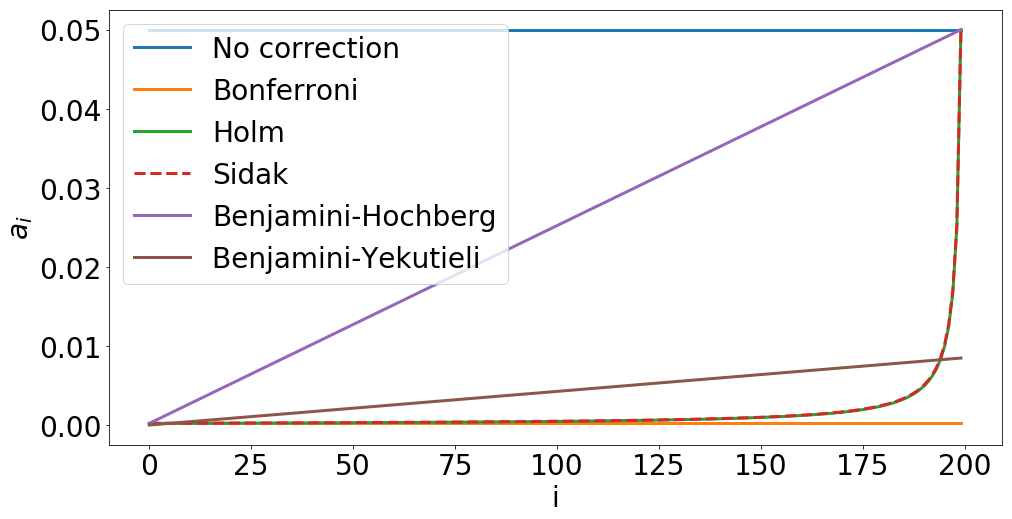

In [9]:
# no correction
plt.plot([0, m - 1], [alpha] * 2, label='No correction')

# bonferroni
bonferroni = alpha / m
plt.plot([0, m - 1], [bonferroni] * 2, label='Bonferroni')

# holm
holm = alpha / np.arange(m, 0, -1)
plt.plot(holm, label='Holm')

# sidak
sidak = 1 - np.power((1. - alpha),  1. / np.arange(m, 0, -1))
plt.plot(sidak, label='Sidak', ls='--')

# benjamini-hochberg
ecdffactor = np.arange(1, m + 1)/float(m)
bh = alpha * ecdffactor
plt.plot(range(m), bh, label='Benjamini-Hochberg' )

# benjamini-yekutieli 
cm = np.sum(1. / np.arange(1, m+1)) 
ecdffactor = ecdffactor / cm
by = alpha * ecdffactor
plt.plot(range(m), by, label='Benjamini-Yekutieli ' )

plt.xlabel('i')
plt.ylabel('$a_i$')
plt.legend(loc='best')

plt.show()

### График модифицированых уровней значимости

In [10]:
def plot_diff_alpha(p_values, loc_plt=None):
    '''
    Функция для отрисовки модифицированых, отсортированых 
    уровней значимости для модельной выборки.
    
    param: p_values --- список уровней значимости
    param: loc_plt --- объект matplotlib.pylab где производится отрисовка
    
    return: loc_plt --- объект matplotlib.pylab после отрисовки
    '''
    if loc_plt is None:
        return None
    argsorted_p = np.argsort(p_values)
    false = []
    true = []
    for i, id in enumerate(argsorted_p):   
        if id>m0:
            false.append((i, p_values[id]))
        else:
            true.append((i, p_values[id]))
    
    loc_plt.scatter(*zip(*true), label='True hypothesis', c='b')
    loc_plt.scatter(*zip(*false), label='False hypothesis', c='r')
    loc_plt.xlabel('sorted i')
    loc_plt.ylabel('$\hat{p}(i)$')
    loc_plt.legend(loc='best')
    
    return loc_plt

#### No corrections

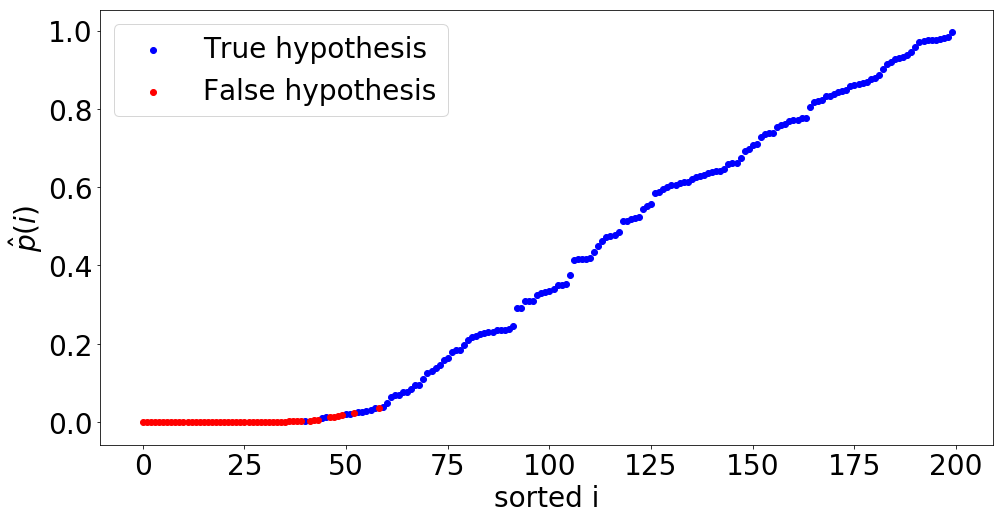

In [11]:
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
        
plot_diff_alpha(p_values, loc_plt=plt)
plt.show()

#### Bonferroni

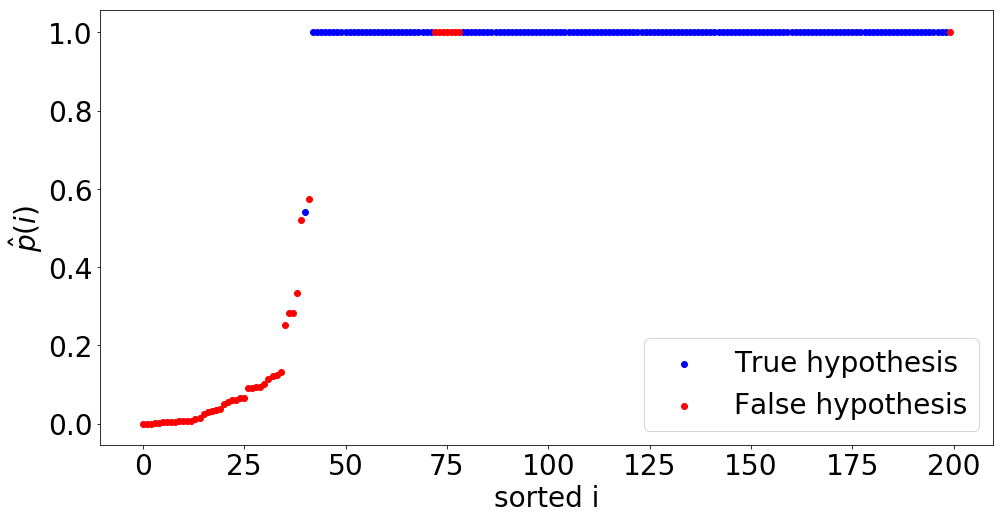

In [12]:
### Ваш код тут
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='bonferroni')[1]
        
plot_diff_alpha(p_values, loc_plt=plt)
plt.show()
###

#### Holm

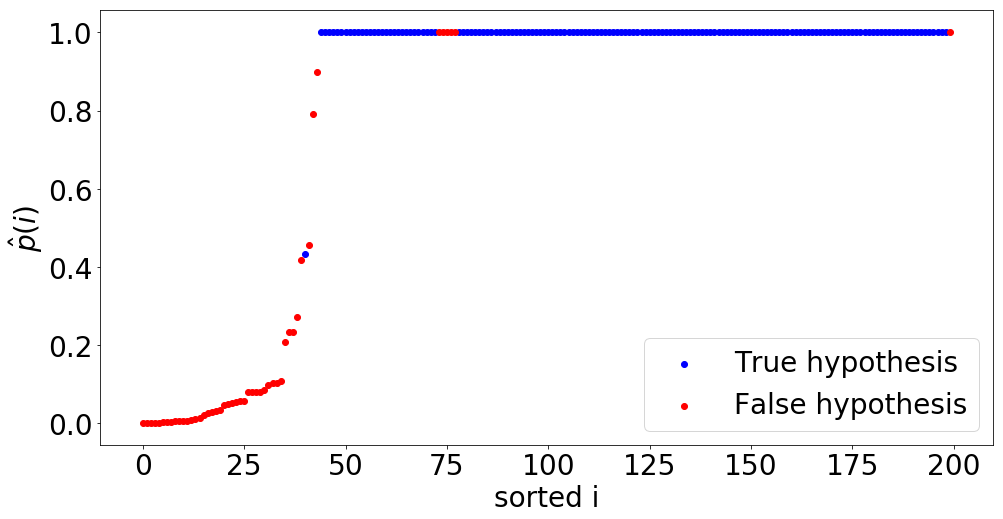

In [13]:
### Ваш код тут
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='holm')[1]
        
plot_diff_alpha(p_values, loc_plt=plt)
plt.show()
###

#### Holm-Sidak

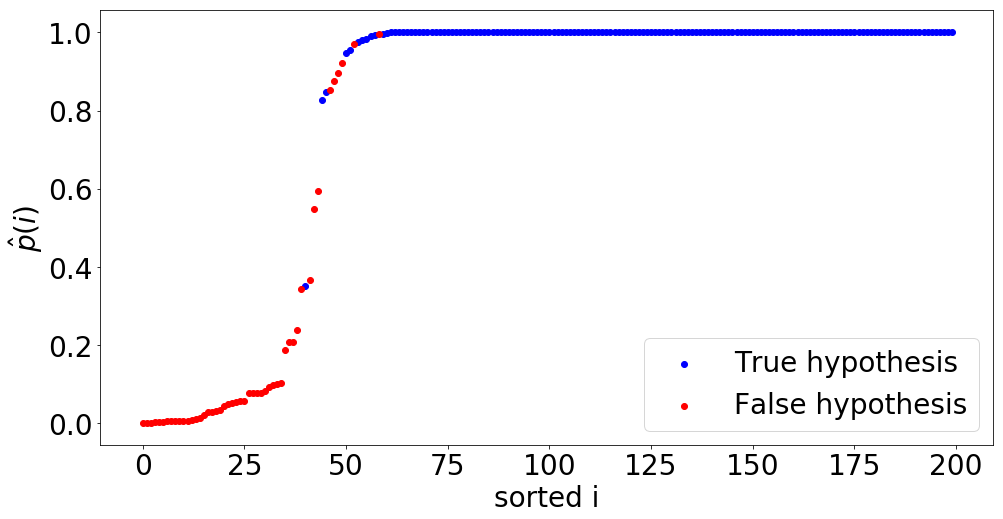

In [14]:
### Ваш код тут
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='holm-sidak')[1]
        
plot_diff_alpha(p_values, loc_plt=plt)
plt.show()
###

#### Benjamini-Hochberg

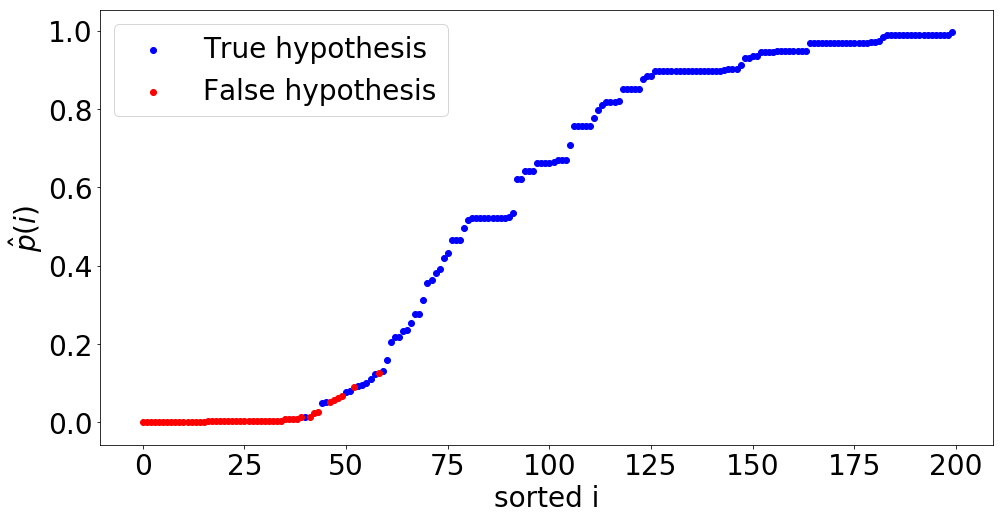

In [15]:
### Ваш код тут
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='fdr_bh')[1]
        
plot_diff_alpha(p_values, loc_plt=plt)
plt.show()
###

#### Benjamini-Yekutieli

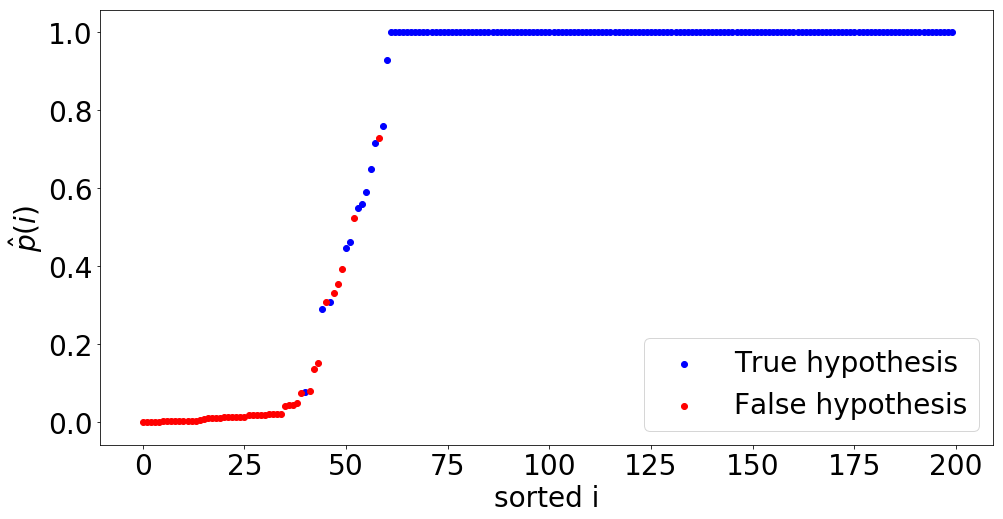

In [16]:
### Ваш код тут
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='fdr_by')[1]
        
plot_diff_alpha(p_values, loc_plt=plt)
plt.show()
###